# Make NSA Catalog with 2MASS magnitudes and UV SFR

In [1]:
import numpy as np
import h5py
from pydl.pydlutils.spheregroup import spherematch
from ChangTools.fitstables import mrdfits

import matplotlib.pyplot as plt
from ChangTools.plotting import prettyplot
from ChangTools.plotting import prettycolors
%matplotlib inline 

/usr/local/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
prettyplot()
pretty_colors = prettycolors()

In [3]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [4]:
local_dir = '/Volumes/750GB/hahn/cenque/observations/'

### Import v_0_1_2 NSA

In [5]:
nsa_data = mrdfits(local_dir+'nsa_v0_1_2.fits')
print len(nsa_data.ra), 'galaxies'

145155 galaxies


In [6]:
print nsa_data.__dict__.keys()

['hafluxerr', 'platequality', 'havmeas', 'dversion', 'b300', 'o3ewerr', 'ahdewerr', 'isdss', 'o3fluxerr', 'profmean_ivar', 's2fluxerr', 'z', 'dflags', 'o2flux', 'hbfluxerr', 'nmgy_ivar', 'd4000', 'ra', 'o1ew', 'plate', 'n2flux', 'haflux', 'ba50', 'petroth50', 'zlg', 'absmag', 'racat', 'vdisp', 'o1ewerr', 'ne3ew', 'programname', 'hbvmeas', 'haew', 'mets', 'profmean', 'sersicflux', 'nmgy', 'ahdew', 'o1flux', 'ne5ew', 'phi50', 'petrotheta', 'proftheta', 'ahgewerr', 'd4000err', 'o3vmerr', 'plug_dec', 'izcat', 'subdir', 'o2ew', 'o2vmeas', 'run', 'faerr', 'ypos', 'asymmetry', 'o1fluxerr', 'ahgew', 'o2ewerr', 's2flux', 'fiberflux', 'amivar', 'dec', 'ok', 'sersic_ba', 'n2fluxerr', 'iauname', 'n2ewerr', 'petroflux_ivar', 'itwodf', 'haewerr', 'camcol', 'zsrc', 'petroflux', 'isixdf', 'o1vmeas', 'o3ew', 'n2vmeas', 'extinction', 'ycen', 'size', 'hbflux', 'havmerr', 'ined', 'phistokes', 'kcorrect', 'b1000', 'xpos', 'rnmgy', 'qstokes', 'hbvmerr', 'ne3ewerr', 'clumpy', 'sersic_n', 'o2vmerr', 'o3flux',

### Import 2MASS catalog from VAGC link

In [7]:
twomass_data = mrdfits(local_dir+'object_twomass.fits')
print len(twomass_data.ra), 'galaxies'

2506754 galaxies


### Match up 2MASS J, H, K magnitues with NSA and save everything into dictionary

In [8]:
m_nsa_2mass, m_2mass_nsa, dd = spherematch(nsa_data.ra, nsa_data.dec, twomass_data.ra, twomass_data.decl, 0.001)

In [9]:
nsa = {} 
for key in nsa_data.__dict__.keys(): 
    nsa[key] = getattr(nsa_data, key)

In [10]:
# 2MASS apparent magnitudes
for band in ['j', 'h', 'k']:  # 2MASS bands
    for tag in ['_k20fe', '_ext', '_fe']:
        nsa['2mass_'+band+'_m'+tag] = np.repeat(-999., len(nsa['ra']))
        nsa['2mass_'+band+'_msig'+tag] = np.repeat(-999., len(nsa['ra']))
        nsa['2mass_'+band+'_absmag'+tag] = np.repeat(-999., len(nsa['ra']))
        
        nsa['2mass_'+band+'_m'+tag][m_nsa_2mass] = getattr(twomass_data, band+'_m'+tag)[m_2mass_nsa]
        nsa['2mass_'+band+'_msig'+tag][m_nsa_2mass] = getattr(twomass_data, band+'_msig'+tag)[m_2mass_nsa]

In [21]:
d_L = cosmo.luminosity_distance(nsa['z'][m_nsa_2mass]).value # luminosity distance
#d_L = (1.+nsa['z'][m_nsa_2mass])*d_m.value
for band in ['j', 'h', 'k']: 
    for tag in ['_k20fe', '_ext', '_fe']:         
        nsa['2mass_'+band+'_absmag'+tag][m_nsa_2mass] = nsa['2mass_'+band+'_m'+tag][m_nsa_2mass] - 5.*(np.log10(d_L*1e6) - 1.)
        print nsa['2mass_'+band+'_absmag'+tag][m_nsa_2mass][:10]

[-21.29169772 -21.26281398 -22.75806779 -23.5353343  -21.01048355
 -21.22817241 -23.58230295 -22.32510998 -21.98991634 -21.65450541]
[-21.38669798 -21.56881374 -22.95706719 -23.64233465 -21.07248382
 -21.33417235 -23.78430261 -22.46610978 -22.368917   -21.7585055 ]
[-21.35169813 -21.46881336 -22.83106774 -23.6223342  -21.04048328
 -21.28717242 -23.59230222 -22.37910988 -22.34091617 -21.76250521]
[-21.98069784 -22.04281372 -23.565067   -24.22133417 -36.70348339
 -22.01017199 -24.2793025  -23.05411007 -22.47991611 -22.13050524]
[-22.10969756 -22.21781391 -23.74806756 -24.36433382 -21.83848361
 -22.34717284 -24.48730268 -23.24910977 -22.97291614 -22.15750567]
[-22.04769728 -22.15681404 -23.6370675  -24.29933424 -36.70348339
 -22.15517245 -24.28830232 -23.12910988 -22.86091663 -22.22850577]
[-22.28569815 -22.2868132  -23.93206758 -24.49333449 -22.261483
 -22.23817264 -24.61630239 -23.39110997 -22.80091621 -22.67550531]
[-22.40269778 -22.66581386 -24.09106702 -24.62033434 -22.41648368
 -22.

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log10


## Calculate $SFR_{UV}$ 
These functions are from Nitya's code

In [12]:
def jansky(flux, kcorrect):
    '''Getting fluxes in Janskies from Nanomaggies:
    Inputs: Choose Petrosian/Sersic Nmgy and the relevant Kcorrection
    '''
    flux_in_Jy = flux*3631*(10.0**(-9.0))*(10**(kcorrect/(-2.5)))
    return flux_in_Jy

In [13]:
def jansky_err(flux,kcorrect):
    '''Inverse Variance in Fluxes: (Input Flux inverse variance in Nmgy^-2)
    '''
    Jy_err = (flux**(-0.5))*3631*(10.0**(-9.0))*(10**(kcorrect/(-2.5)))
    return Jy_err

In [14]:
def UVsfr(z,fmag,nmag,rmag,f_flux):
    ''' Calculate UV star formation rates. 
    Inputs: NSAID,z,F-band magnitude, N-band magnitude, r-band magnitude, F-band flux in Janskies
    '''
    fn = fmag - nmag
    opt = nmag - rmag   # N-r
    
    #Luminosity Distance
    dist = cosmo.comoving_distance(z)
    ldist = (1+z)*dist
    
    #calculating Attenuation 'atten'
    atten = np.repeat(-999., len(fmag)) 

    case1 = np.where((opt > 4.) & (fn < 0.95)) 
    atten[case1] = 3.32*fn[case1] + 0.22
    case2 = np.where((opt > 4.) & (fn >= 0.95))
    atten[case2] = 3.37
    case3 = np.where((opt <= 4.) & (fn < 0.9))
    atten[case3] = 2.99*fn[case3] + 0.27
    case4 = np.where((opt <= 4.) & (fn >= 0.9))
    atten[case4] = 2.96

    #if opt >= 4.0:
    #    if fn < 0.95:
    #        atten = 3.32*fn + 0.22
    #    else:
    #        atten = 3.37
    #else:
    #    if fn < 0.90:
    #        atten = 2.99*fn +0.27
    #    else:
    #        atten = 2.96

    lum = 4.*np.pi*(ldist**2.0)*(3.087**2.0)*(10**(25.0 +(atten/2.5)))*f_flux  #Luminosity
    sfr = 1.08*(10**(-28.0))*np.abs(lum)
    return sfr

In [15]:
def NSA_SFR_UV(nsa_data, flux_choice): 
    ''' Given NSA data dictionary calculate the UV sfrs 
    '''
    if flux_choice not in ['elpetro', 'sersic']: 
        raise ValueError
        
    if flux_choice == 'elpetro': 
        flux_tag = 'petroflux'
    elif flux_choice == 'sersic': 
        flux_tag = 'sersicflux'

    fuv_nanomags = nsa_data[flux_tag][:,0]
    not_nans = (fuv_nanomags > 0.) 
    print len(fuv_nanomags) - np.sum(not_nans), " galaxies don't have UV"

    fuv_jansky = np.repeat(-999., len(fuv_nanomags))
    fuv_jansky[np.where(not_nans)] = jansky(fuv_nanomags[np.where(not_nans)], 0.) 

    absmags = nsa_data['absmag']
    f_notnans = (absmags[:,0] != -9999.)
    n_notnans = (absmags[:,1] != -9999.)
    r_notnans = (absmags[:,4] != -9999.)
    
    has_everything = np.where(not_nans & f_notnans & n_notnans & r_notnans)
    uvsfrs = np.repeat(-999., len(fuv_nanomags))
    uvsfrs[has_everything] = UVsfr(
            nsa_data['z'][has_everything], 
            absmags[:,0][has_everything], 
            absmags[:,1][has_everything], 
            absmags[:,4][has_everything], 
            fuv_jansky[has_everything])

    return uvsfrs 

### Add $SFR_{UV}$ values to NSA dictionary

In [16]:
nsa['sfr_uv_elpetro'] = NSA_SFR_UV(nsa, 'elpetro')
nsa['sfr_uv_sersic'] = NSA_SFR_UV(nsa, 'sersic')

28429  galaxies don't have UV
26351  galaxies don't have UV


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in greater


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log10


(-3.0, 3.0)

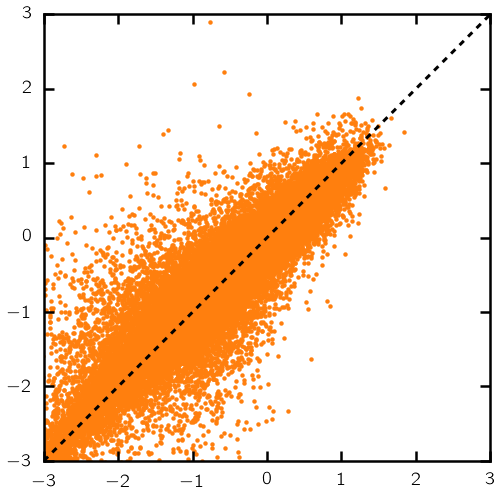

In [17]:
fig = plt.figure(figsize=(8,8))
sub = fig.add_subplot(111)

sub.scatter(np.log10(nsa['sfr_uv_elpetro']), np.log10(nsa['sfr_uv_sersic']), c=pretty_colors[3], lw=0)

sub.plot([-3.,3.], [-3.,3.], c='k', ls='--', lw=3)
sub.set_xlim([-3., 3.])
sub.set_ylim([-3., 3.])

# Save NSA dictionary 

In [18]:
import pickle

In [19]:
pickle.dump(nsa, open(local_dir+'NSA_2MASS_UVSFR.p', 'wb'))